# São Paulo Subway - EDA Passenger Transported Demand by line

from August 2018 to April 2023.

Import libaries

In [4]:
from matplotlib.style import use

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline
use('seaborn-v0_8')

Read CSV file.

In [5]:
PATH = 'alllines_ptl_complete.csv'
df = pd.read_csv(PATH, index_col='year_month')
display(df)

,line,total,MDU (Business Days Mean),MSD (Saturdays Mean),MDO (Sundays Mean),MAX (Daily Max)
year_month,,,,,,
2018-08-01,3,38679000.0,1440000.0,884000.0,504000.0,1483000.0
2018-08-01,1,37775000.0,1420000.0,832000.0,446000.0,1466000.0
2018-08-01,15,516000.0,22000.0,3000.0,2000.0,23000.0
2018-08-01,2,18164000.0,701000.0,318000.0,194000.0,723000.0
2018-08-01,5,7220000.0,309000.0,176000.0,85000.0,322000.0
...,...,...,...,...,...,...
2023-04-01,2,14544000.0,649000.0,299000.0,189000.0,671000.0
2023-04-01,4,15070570.0,661450.0,338300.0,201580.0,701710.0
2023-04-01,5,11792220.0,510810.0,282420.0,160710.0,527250.0


## Visualization

[]

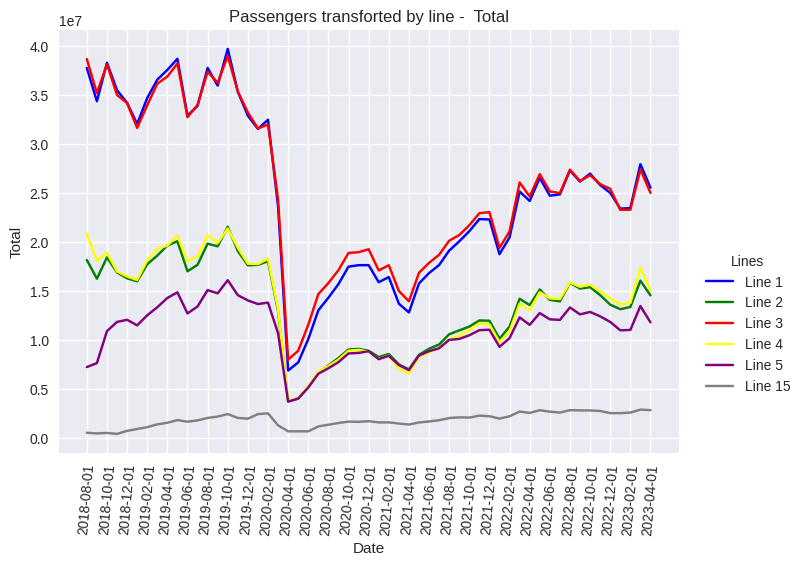

In [7]:
plt.plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'total'], label='Line 1', color='blue')
plt.plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'total'], label='Line 2', color='green')
plt.plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'total'], label='Line 3', color='red')
plt.plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'total'], label='Line 4', color='yellow')
plt.plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'total'], label='Line 5', color='purple')
plt.plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'total'], label='Line 15', color='gray')
plt.title('Passengers transforted by line -  Total')
plt.xlabel('Date')
plt.ylabel('Total')
plt.xticks(ticks=list(np.unique(df.index))[::2], rotation=85)
plt.legend(bbox_to_anchor=(0.7, 0., 0.5, 0.5), title='Lines')
plt.plot()

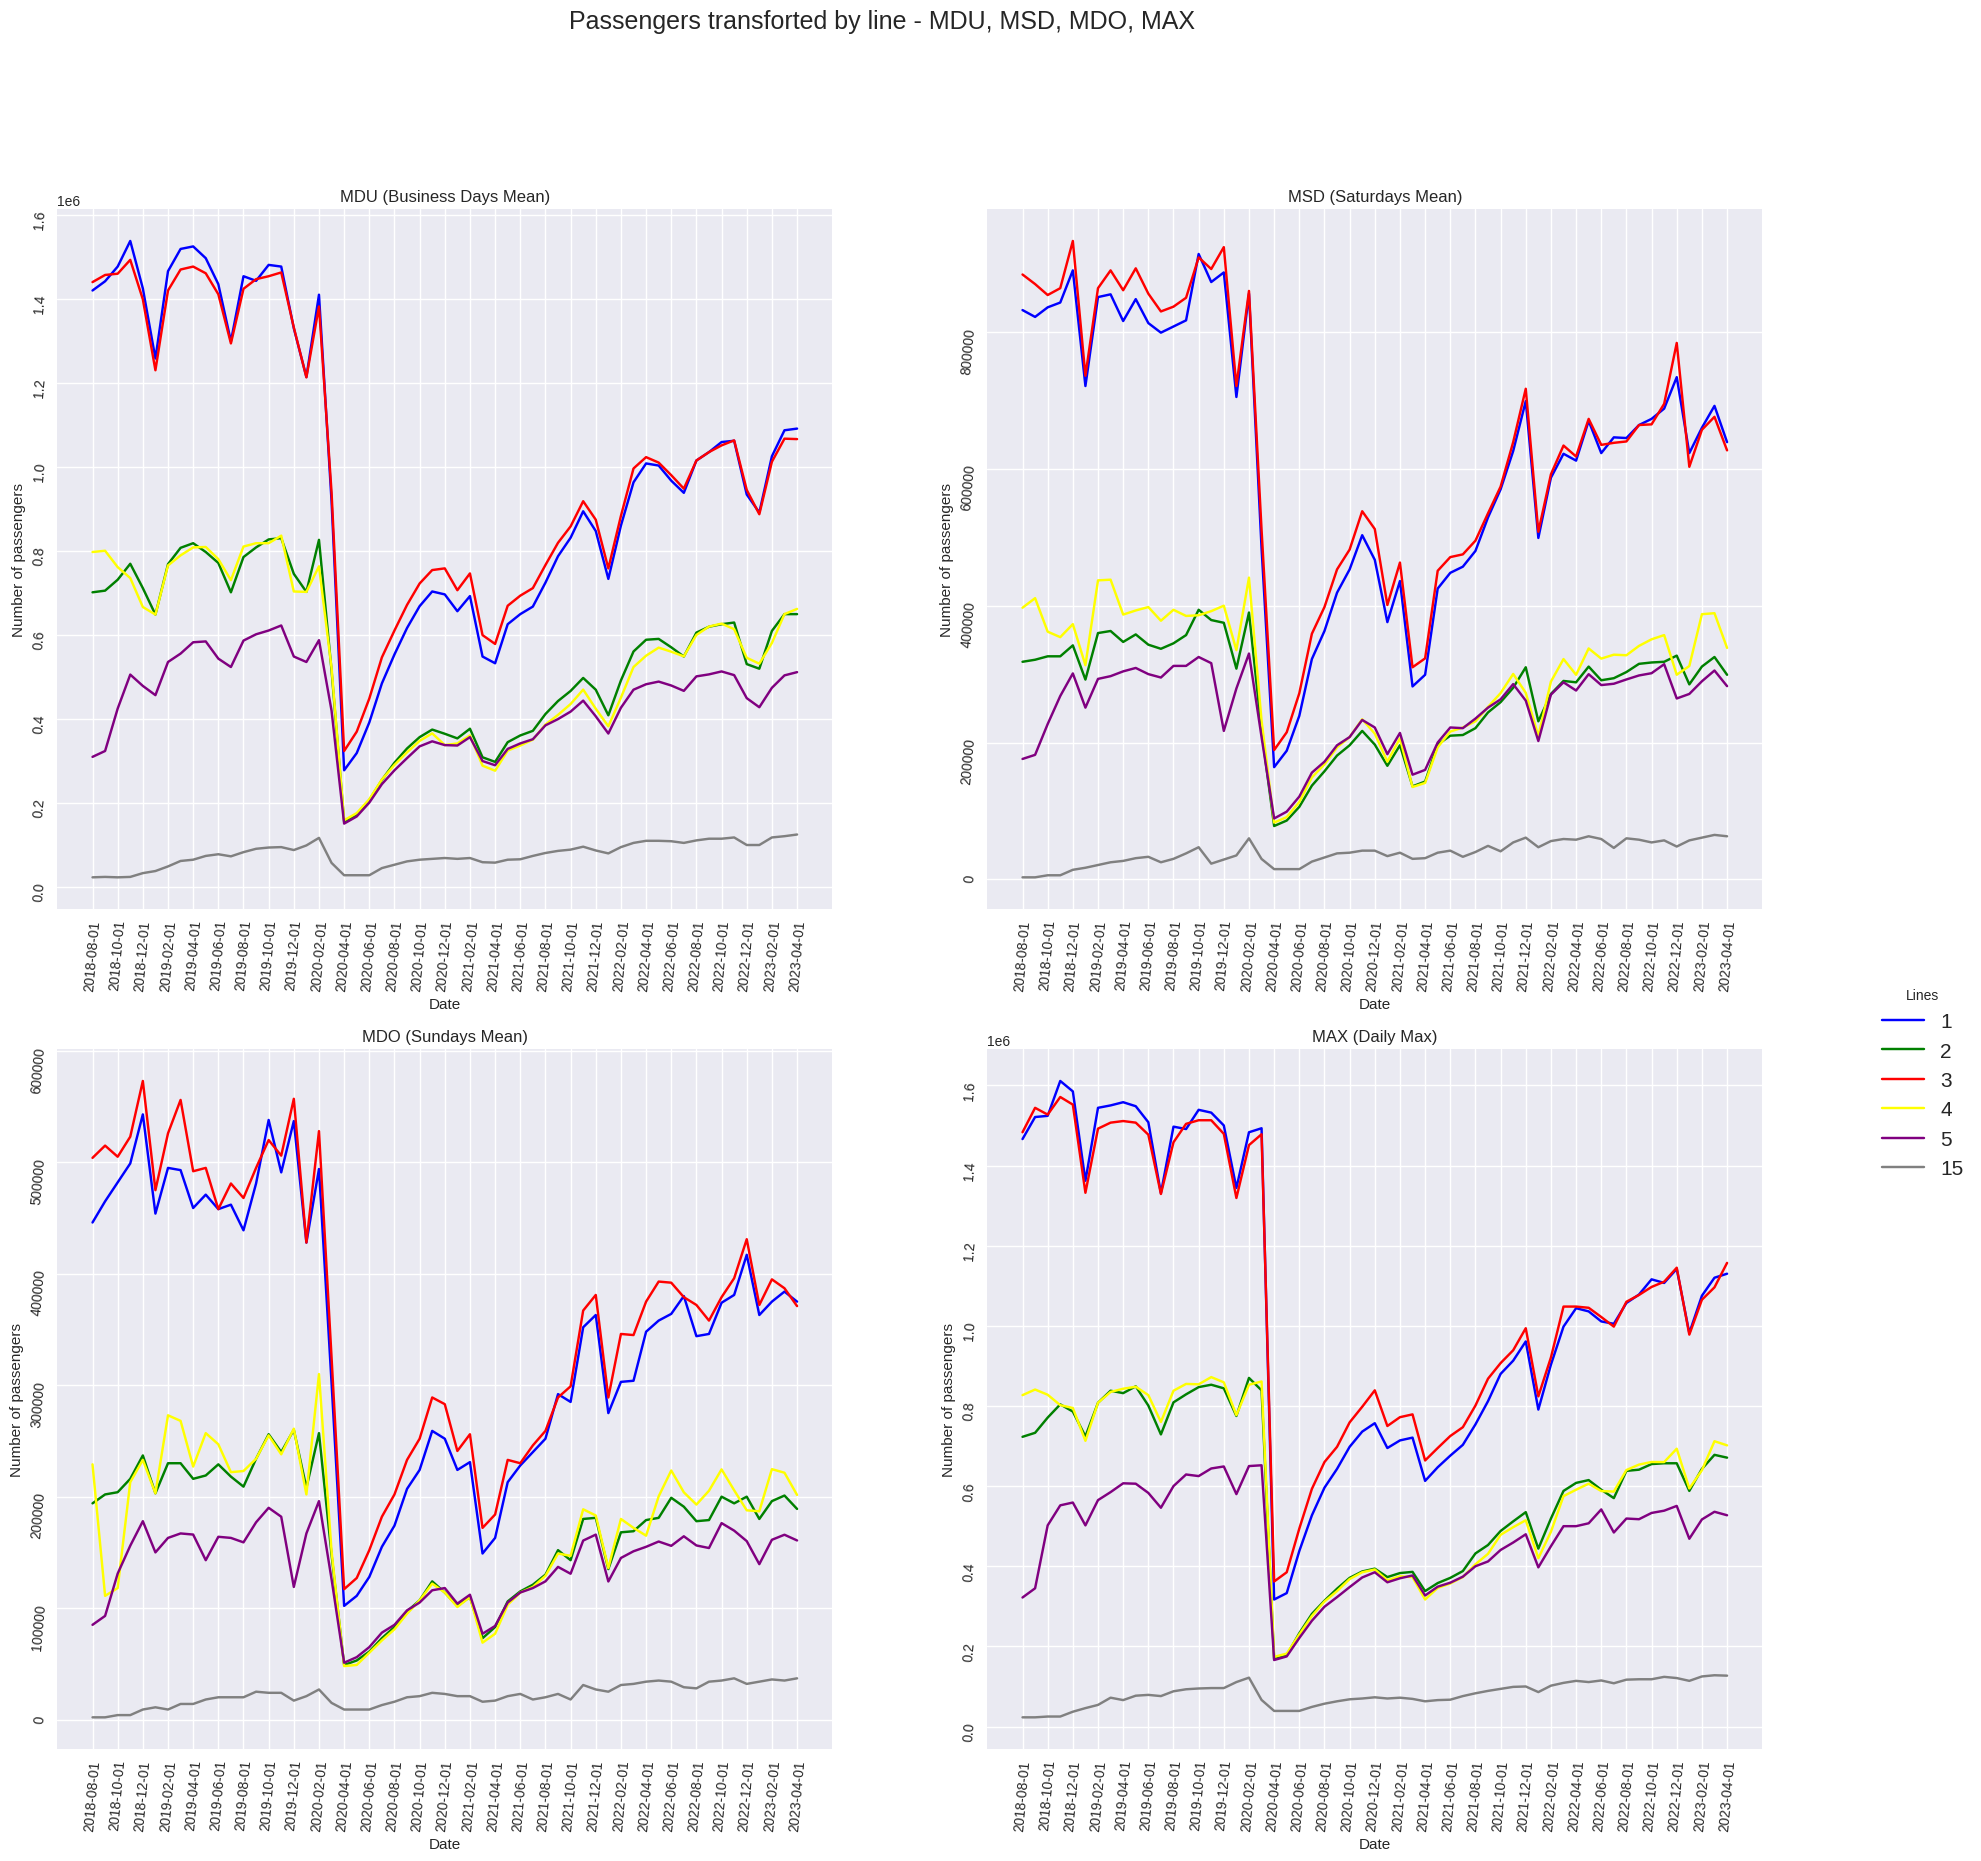

In [8]:
color_lines = {1: 'blue', 2: 'green', 3: 'red', 4: 'yellow', 5: 'purple', 15: 'gray'}

figure = plt.figure(figsize=(22, 20))
axs = figure.subplots(nrows=2, ncols=2)
figure.suptitle('Passengers transforted by line - MDU, MSD, MDO, MAX', fontsize=18)

axs[0][0].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MDU (Business Days Mean)'], label='Line 1', color=color_lines[1])
axs[0][0].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MDU (Business Days Mean)'], label='Line 2', color=color_lines[2])
axs[0][0].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MDU (Business Days Mean)'], label='Line 3', color=color_lines[3])
axs[0][0].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MDU (Business Days Mean)'], label='Line 4', color=color_lines[4])
axs[0][0].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MDU (Business Days Mean)'], label='Line 5', color=color_lines[5])
axs[0][0].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MDU (Business Days Mean)'], label='Line 15', color=color_lines[15])
axs[0][0].set_title('MDU (Business Days Mean)')
axs[0][0].set_xlabel('Date')
axs[0][0].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[0][0].tick_params(labelrotation=85)
axs[0][0].set_ylabel('Number of passengers')

axs[0][1].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MSD (Saturdays Mean)'], label='Line 1', color=color_lines[1])
axs[0][1].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MSD (Saturdays Mean)'], label='Line 2', color=color_lines[2])
axs[0][1].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MSD (Saturdays Mean)'], label='Line 3', color=color_lines[3])
axs[0][1].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MSD (Saturdays Mean)'], label='Line 4', color=color_lines[4])
axs[0][1].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MSD (Saturdays Mean)'], label='Line 5', color=color_lines[5])
axs[0][1].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MSD (Saturdays Mean)'], label='Line 15', color=color_lines[15])
axs[0][1].set_title('MSD (Saturdays Mean)')
axs[0][1].set_xlabel('Date')
axs[0][1].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[0][1].tick_params(labelrotation=85)
axs[0][1].set_ylabel('Number of passengers')

axs[1][0].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MDO (Sundays Mean)'], label='Line 1', color=color_lines[1])
axs[1][0].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MDO (Sundays Mean)'], label='Line 2', color=color_lines[2])
axs[1][0].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MDO (Sundays Mean)'], label='Line 3', color=color_lines[3])
axs[1][0].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MDO (Sundays Mean)'], label='Line 4', color=color_lines[4])
axs[1][0].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MDO (Sundays Mean)'], label='Line 5', color=color_lines[5])
axs[1][0].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MDO (Sundays Mean)'], label='Line 15', color=color_lines[15])
axs[1][0].set_title('MDO (Sundays Mean)')
axs[1][0].set_xlabel('Date')
axs[1][0].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[1][0].tick_params(labelrotation=85)
axs[1][0].set_ylabel('Number of passengers')

axs[1][1].plot(df[df['line'] == 1].index, df[df['line'] == 1].loc[:,'MAX (Daily Max)'], label='Line 1', color=color_lines[1])
axs[1][1].plot(df[df['line'] == 2].index, df[df['line'] == 2].loc[:,'MAX (Daily Max)'], label='Line 2', color=color_lines[2])
axs[1][1].plot(df[df['line'] == 3].index, df[df['line'] == 3].loc[:,'MAX (Daily Max)'], label='Line 3', color=color_lines[3])
axs[1][1].plot(df[df['line'] == 4].index, df[df['line'] == 4].loc[:,'MAX (Daily Max)'], label='Line 4', color=color_lines[4])
axs[1][1].plot(df[df['line'] == 5].index, df[df['line'] == 5].loc[:,'MAX (Daily Max)'], label='Line 5', color=color_lines[5])
axs[1][1].plot(df[df['line'] == 15].index, df[df['line'] == 15].loc[:,'MAX (Daily Max)'], label='Line 15', color=color_lines[15])
axs[1][1].set_title('MAX (Daily Max)')
axs[1][1].set_xlabel('Date')
axs[1][1].set_xticks(ticks=list(np.unique(df.index))[::2])
axs[1][1].tick_params(labelrotation=85)
axs[1][1].set_ylabel('Number of passengers')

figure.legend(labels=color_lines.keys(),bbox_to_anchor=(0.5, 0., 0.5, 0.5), title='Lines', fontsize=15)
plt.show()

### Lines 1 and 3 participation in total of passenger transported demand by line

In [9]:
totals = df.groupby(by='year_month').sum().drop(labels='line', axis=1).loc[:,'total']

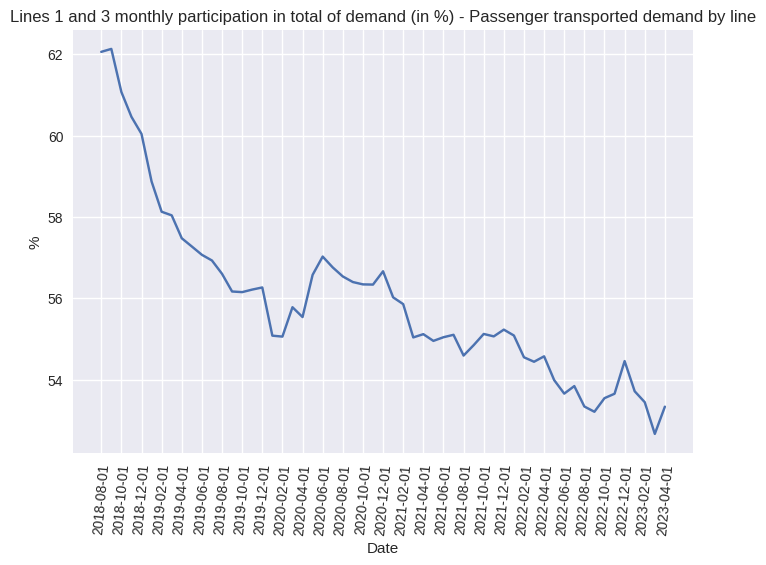

In [11]:
line_01_sum = df[df.loc[:,'line'] == 1].loc[:,'total']
line_03_sum = df[df.loc[:,'line'] == 3].loc[:,'total']
participation_line1_line2 = ((line_01_sum + line_03_sum) / totals) * 100

plt.plot(participation_line1_line2) 
plt.title('Lines 1 and 3 monthly participation in total of demand (in %) - Passenger transported demand by line')
plt.xlabel('Date')
plt.ylabel('%')
plt.xticks(ticks=list(np.unique(df.index))[::2], rotation=85)
plt.show()

#### Question:

If the monthly share of the two lines with the highest passenger demand is decreasing over time, is there any possibility that other lines are growing?

### The participation of each line in the total demand.

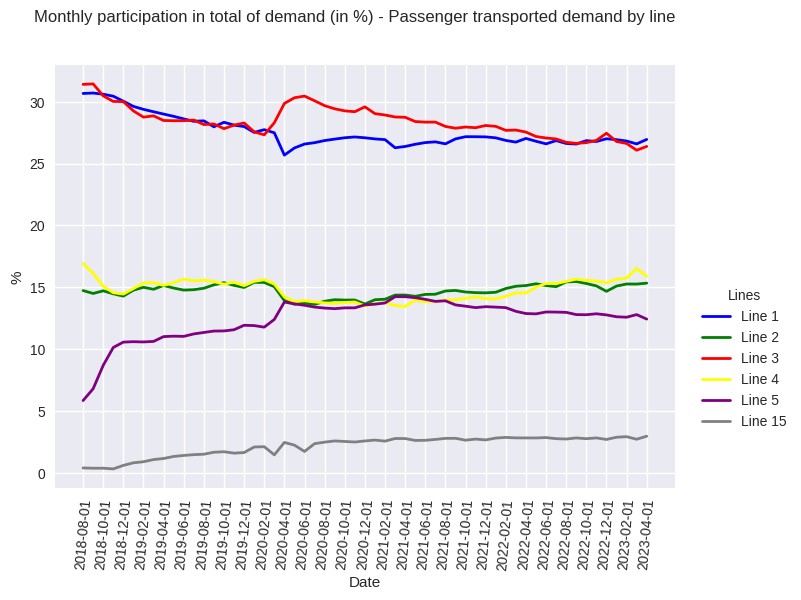

In [12]:
line_01_sum = df[df.loc[:,'line'] == 1].loc[:,'total']
participation_line1 = (line_01_sum / totals) * 100
plt.plot(participation_line1, color=color_lines[1], label='Line 1', linewidth=2)

line_02_sum = df[df.loc[:,'line'] == 2].loc[:,'total']
participation_line2 = (line_02_sum / totals) * 100
plt.plot(participation_line2, color=color_lines[2], label='Line 2', linewidth=2)

line_03_sum = df[df.loc[:,'line'] == 3].loc[:,'total']
participation_line3 = (line_03_sum / totals) * 100
plt.plot(participation_line3, color=color_lines[3], label='Line 3', linewidth=2)

line_04_sum = df[df.loc[:,'line'] == 4].loc[:,'total']
participation_line4 = (line_04_sum / totals) * 100
plt.plot(participation_line4, color=color_lines[4], label='Line 4', linewidth=2)

line_05_sum = df[df.loc[:,'line'] == 5].loc[:,'total']
participation_line5 = (line_05_sum / totals) * 100
plt.plot(participation_line5, color=color_lines[5], label='Line 5', linewidth=2)

line_15_sum = df[df.loc[:,'line'] == 15].loc[:,'total']
participation_line15 = (line_15_sum / totals) * 100
plt.plot(participation_line15, color=color_lines[15], label='Line 15', linewidth=2)

plt.suptitle('Monthly participation in total of demand (in %) - Passenger transported demand by line')
plt.xlabel('Date')
plt.xticks(ticks=list(np.unique(df.index))[::2], rotation=85)
plt.ylabel('%')
plt.legend(bbox_to_anchor=(0.7, 0., 0.5, 0.5), title='Lines')
plt.show()